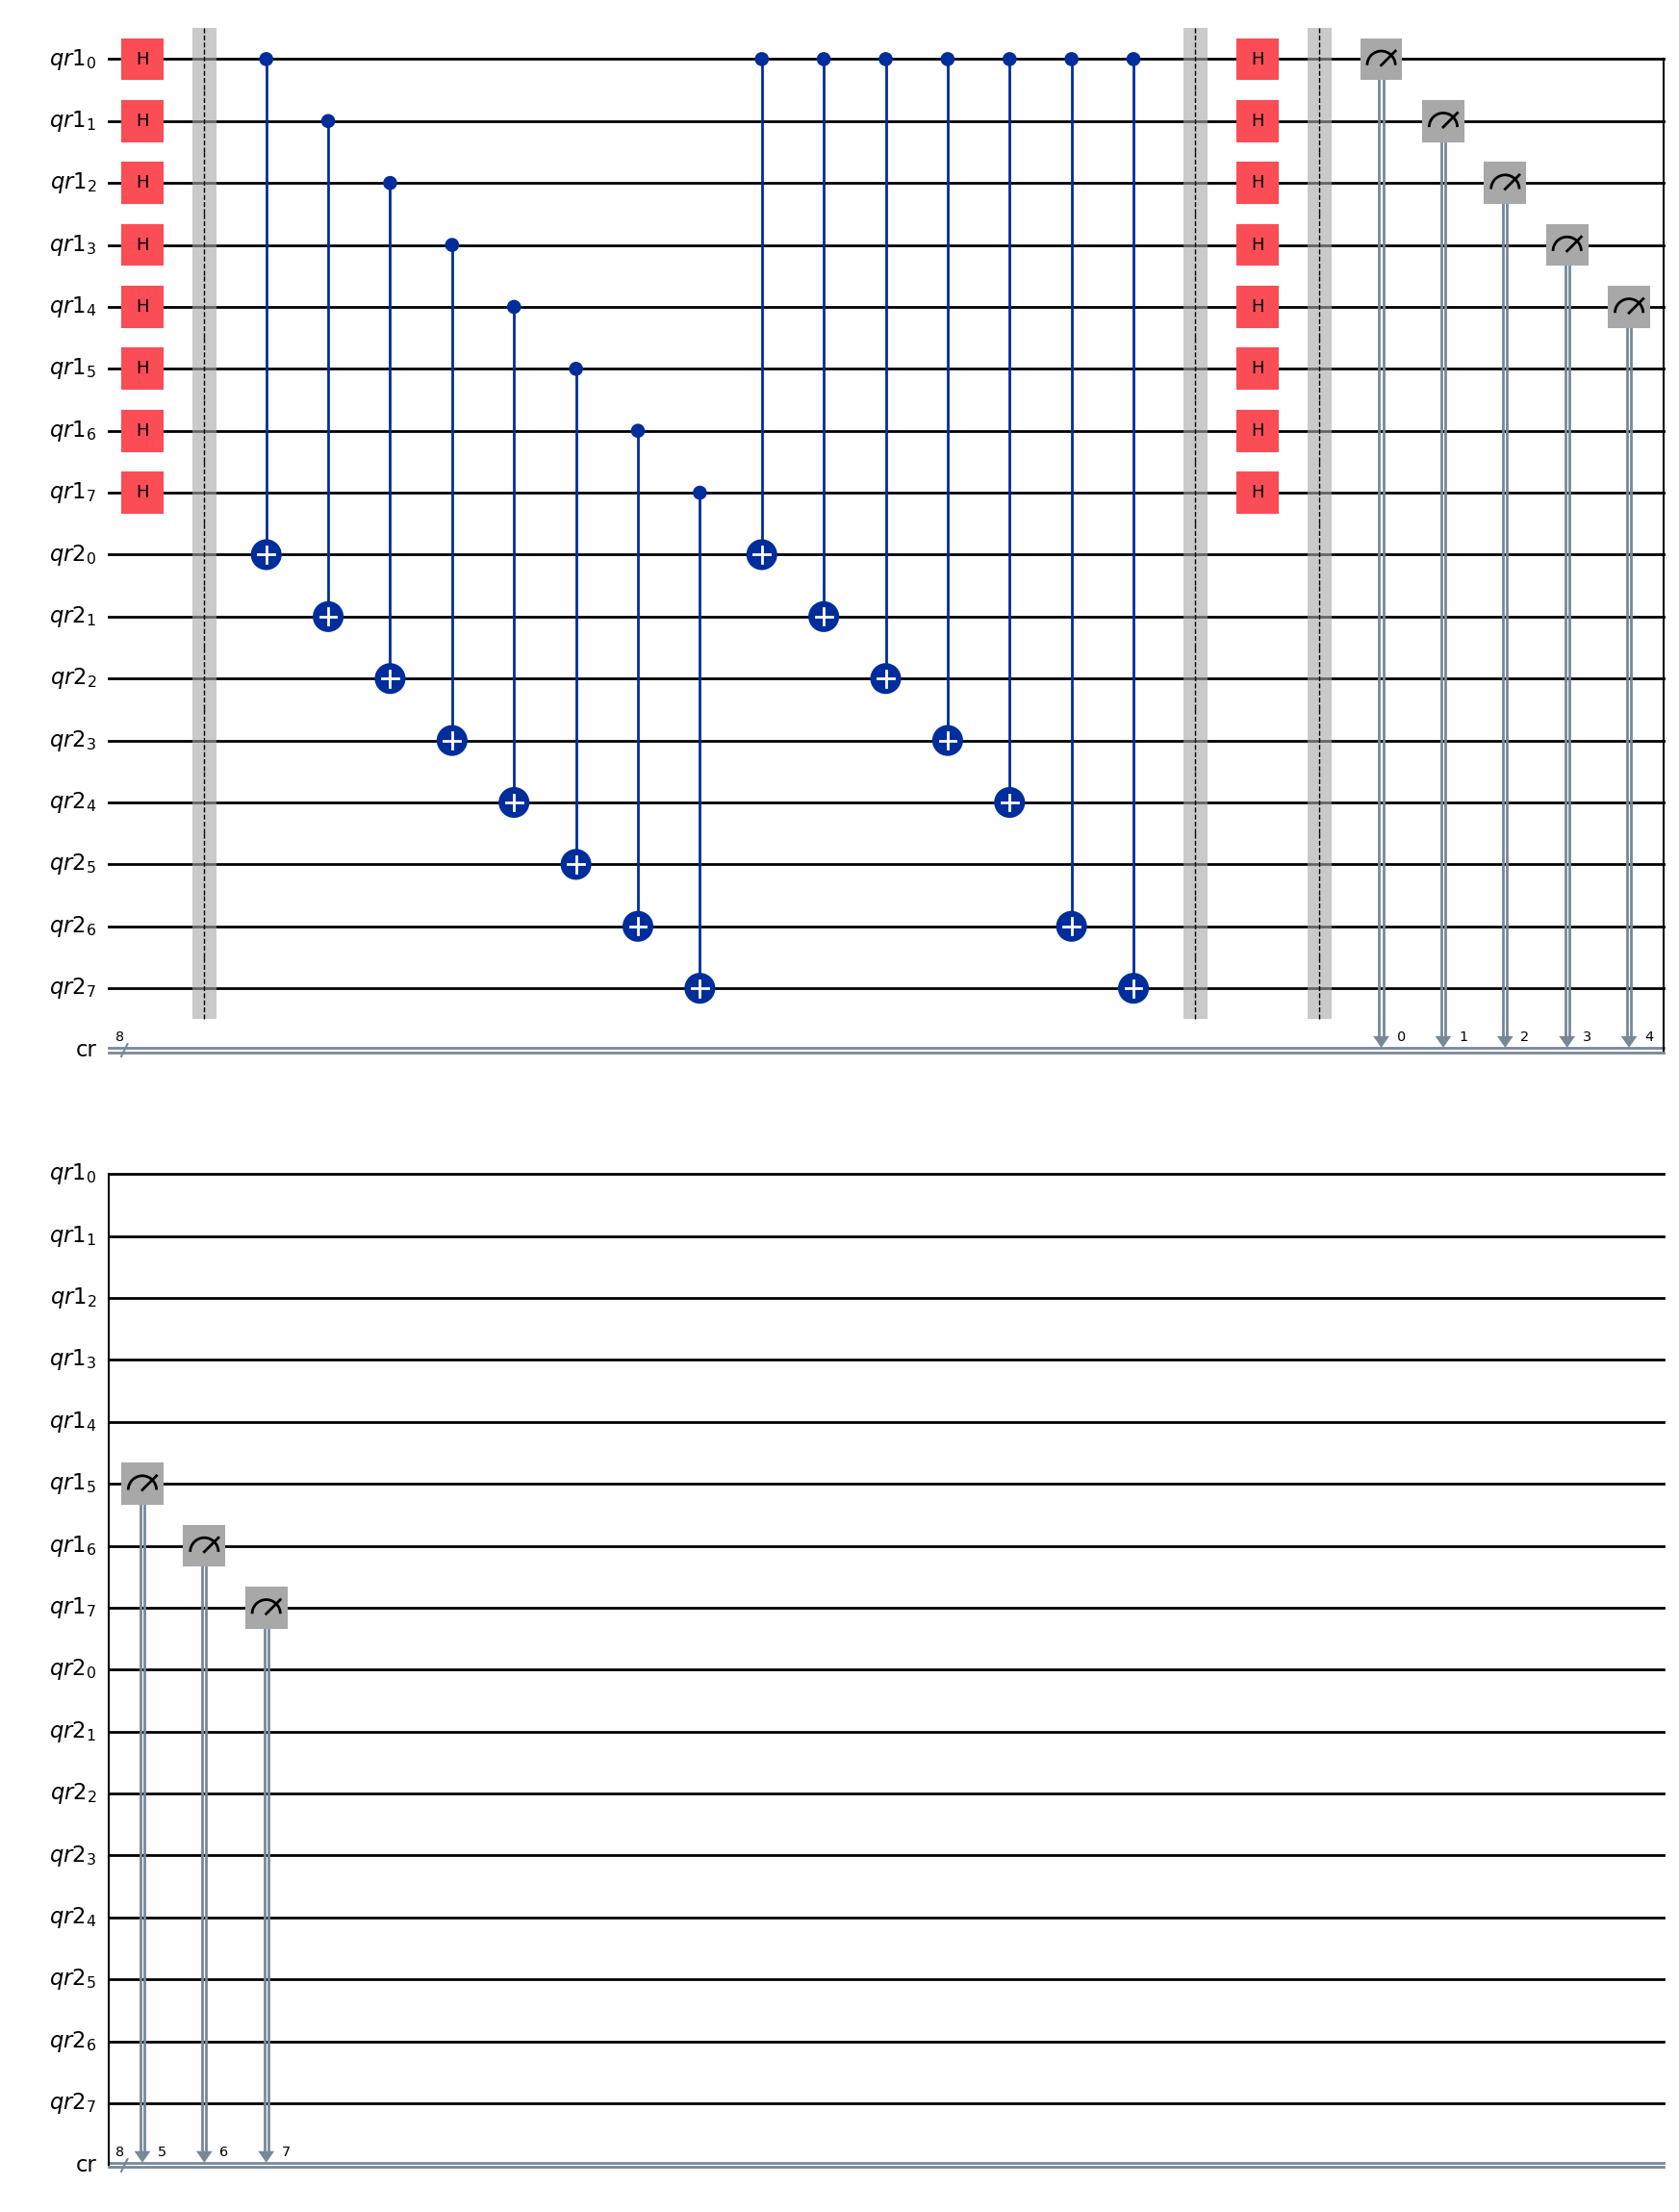

In [7]:
# full algorithm that solves system of equations for any s
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

s = '11011111'

n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

# first round of hadamards
qc.h(qr1)
qc.barrier()

# oracle
qc.cx(qr1, qr2)
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
qc.barrier()

# second round of hadamards
qc.h(qr1)
qc.barrier()

# measurement
qc.measure(qr1, cr)

qc.draw('mpl')

Counts: {'00110001': 5, '00101111': 8, '00000110': 11, '11001010': 11, '11100011': 9, '11111011': 11, '01010011': 10, '10111111': 11, '00100011': 10, '00111101': 10, '11101111': 6, '00001100': 6, '00101010': 13, '10101000': 15, '01000111': 9, '00010001': 14, '11110100': 8, '01101101': 5, '01010000': 8, '01000010': 9, '11001100': 4, '01000100': 5, '01111010': 8, '10011100': 7, '01100001': 9, '11110010': 10, '01101011': 7, '11010100': 8, '01001101': 8, '10010011': 14, '00111110': 9, '00110100': 8, '00101100': 11, '10010110': 7, '11000000': 11, '01111100': 8, '00110111': 5, '00000000': 6, '01011111': 8, '10110011': 8, '01000001': 8, '11110001': 3, '00010100': 10, '00011000': 7, '10111010': 8, '10001110': 6, '11101010': 11, '11000011': 9, '11010010': 12, '10010101': 7, '00001001': 7, '00111000': 11, '01110011': 8, '11110111': 9, '00010010': 6, '00101001': 10, '10111100': 8, '01010110': 6, '10110000': 10, '01011100': 8, '10110110': 13, '00011011': 6, '01100111': 8, '00100110': 4, '01101000'

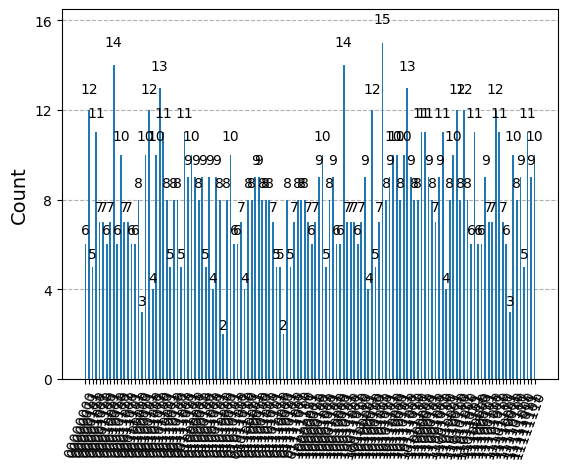

In [8]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
job = simulator.run(qc, shots=1024)
result = job.result()
counts = result.get_counts(qc)
print("Counts:", counts)
plot_histogram(counts)

In [9]:
# finding output values
import numpy as np

# generating all possible binary strings of length n
def generate_binary(n):
    for i in range(2**n):
        yield format(i, '0{}b'.format(n))

# finding probable bits
def findImportantBits(counts):
    for binary_string in generate_binary(n):
        if counts.get(binary_string, 0) > 0:
            yield binary_string
    return None

vals = []
for binary_string in findImportantBits(counts):
    if (binary_string == '0' * n):
        continue
    print(binary_string)
    vals.append( [ int(c) for c in binary_string ] )
numVals = len(vals)

00000011
00000101
00000110
00001001
00001010
00001100
00001111
00010001
00010010
00010100
00010111
00011000
00011011
00011101
00011110
00100000
00100011
00100101
00100110
00101001
00101010
00101100
00101111
00110001
00110010
00110100
00110111
00111000
00111011
00111101
00111110
01000001
01000010
01000100
01000111
01001000
01001011
01001101
01001110
01010000
01010011
01010101
01010110
01011001
01011010
01011100
01011111
01100001
01100010
01100100
01100111
01101000
01101011
01101101
01101110
01110000
01110011
01110101
01110110
01111001
01111010
01111100
01111111
10000001
10000010
10000100
10000111
10001000
10001011
10001101
10001110
10010000
10010011
10010101
10010110
10011001
10011010
10011100
10011111
10100001
10100010
10100100
10100111
10101000
10101011
10101101
10101110
10110000
10110011
10110101
10110110
10111001
10111010
10111100
10111111
11000000
11000011
11000101
11000110
11001001
11001010
11001100
11001111
11010001
11010010
11010100
11010111
11011000
11011011
11011101
11011110
1

In [10]:
# solving system of equations
# found at https://github.com/amazon-braket/amazon-braket-examples/blob/f49bb6a68f1be280e4b00146022c35a5293d2f07/examples/advanced_circuits_algorithms/Simons_Algorithm/Simons_Algorithm.ipynb

from sympy import Matrix

print('The result in matrix form is :')
for a in vals:
    print (a)

M=Matrix(vals).T

# Construct the agumented matrix
M_I = Matrix(np.hstack([M,np.eye(M.shape[0],dtype=int)]))

# Perform row reduction, working modulo 2. We use the iszerofunc property of rref
# to perform the Gaussian elimination over the finite field.
M_I_rref = M_I.rref(iszerofunc=lambda x: x % 2==0)

# In row reduced echelon form, we can end up with a solution outside of the finite field {0,1}.
# Thus, we need to revert the matrix back to this field by treating fractions as a modular inverse.
# Since the denominator will always be odd (i.e. 1 mod 2), it can be ignored.

# Helper function to treat fractions as modular inverse:
def mod2(x):
    return x.as_numer_denom()[0] % 2

# Apply our helper function to the matrix
M_I_final = M_I_rref[0].applyfunc(mod2)

# Extract the kernel of M from the remaining columns of the last row, when s is nonzero.
if all(value == 0 for value in M_I_final[-1,:M.shape[1]]):
    result_s="".join(str(c) for c in M_I_final[-1,M.shape[1]:])

# Otherwise, the sub-matrix will be full rank, so just set s=0...0
else:
    result_s='0'*M.shape[0]

# Check whether result_s is equal to initial s:
print ('Secret string: ' + s)
print ('Result string: ' + result_s)
if (result_s == s):
    print ('We found the correct answer.')
else:
    print ('Error. The answer is wrong!')

The result in matrix form is :
[0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 1, 1, 1]
[0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 0, 1, 1]
[0, 0, 0, 1, 1, 1, 0, 1]
[0, 0, 0, 1, 1, 1, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 1, 1]
[0, 0, 1, 0, 0, 1, 0, 1]
[0, 0, 1, 0, 0, 1, 1, 0]
[0, 0, 1, 0, 1, 0, 0, 1]
[0, 0, 1, 0, 1, 0, 1, 0]
[0, 0, 1, 0, 1, 1, 0, 0]
[0, 0, 1, 0, 1, 1, 1, 1]
[0, 0, 1, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 1, 1, 1]
[0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 1, 1]
[0, 0, 1, 1, 1, 1, 0, 1]
[0, 0, 1, 1, 1, 1, 1, 0]
[0, 1, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 1, 